# GAN

## Libraries

In [1]:
import numpy as np # linear algebra
from numpy.random import randn,random,normal,rand
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as ml
import matplotlib.pyplot as plt
%matplotlib inline

## Data

PLOTTING ORIGINAL IMAGE SAMPLES


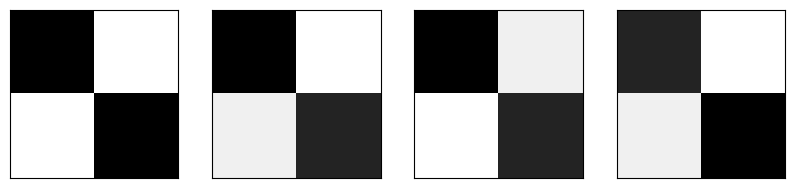

In [2]:
def view_images(matrices,rows,cols):
    fig,axes = plt.subplots(figsize=(10,10),nrows=rows,ncols=cols,sharex=True,sharey=True)
    for axis,image in zip(axes.flatten(),matrices):
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        im = axis.imshow(1-image.reshape((2,2)),cmap='Greys_r')
    return fig,axes

# Viewing sample data
# Original pictures
samples = [np.array([1,0,0,1]),
           np.array([0.9,0.1,0.2,0.8]),
           np.array([0.9,0.2,0.1,0.8]),
           np.array([0.8,0.1,0.2,0.9]),
           np.array([0.8,0.2,0.1,0.9])]


print("PLOTTING ORIGINAL IMAGE SAMPLES")
_ = view_images(matrices = samples,rows = 1,cols = 4)

Plotting Noisy Image Samples


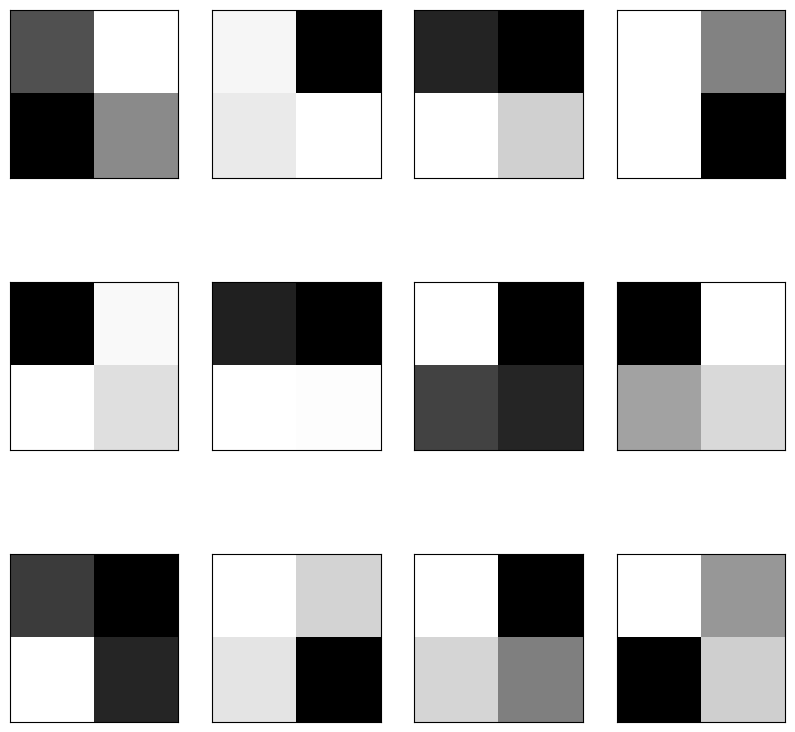

In [4]:
#Viewing sample data
# Noisy data
noise = [np.random.randn(2,2) for i in range(12)]    # 10 images
print("Plotting Noisy Image Samples")
_ = view_images(matrices = noise,rows = 3,cols = 4)

## Neural Networks

### Discriminator

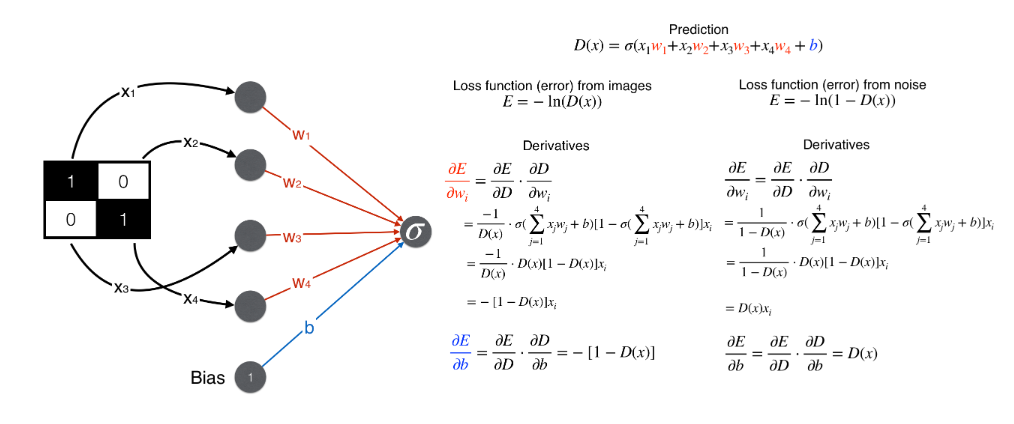
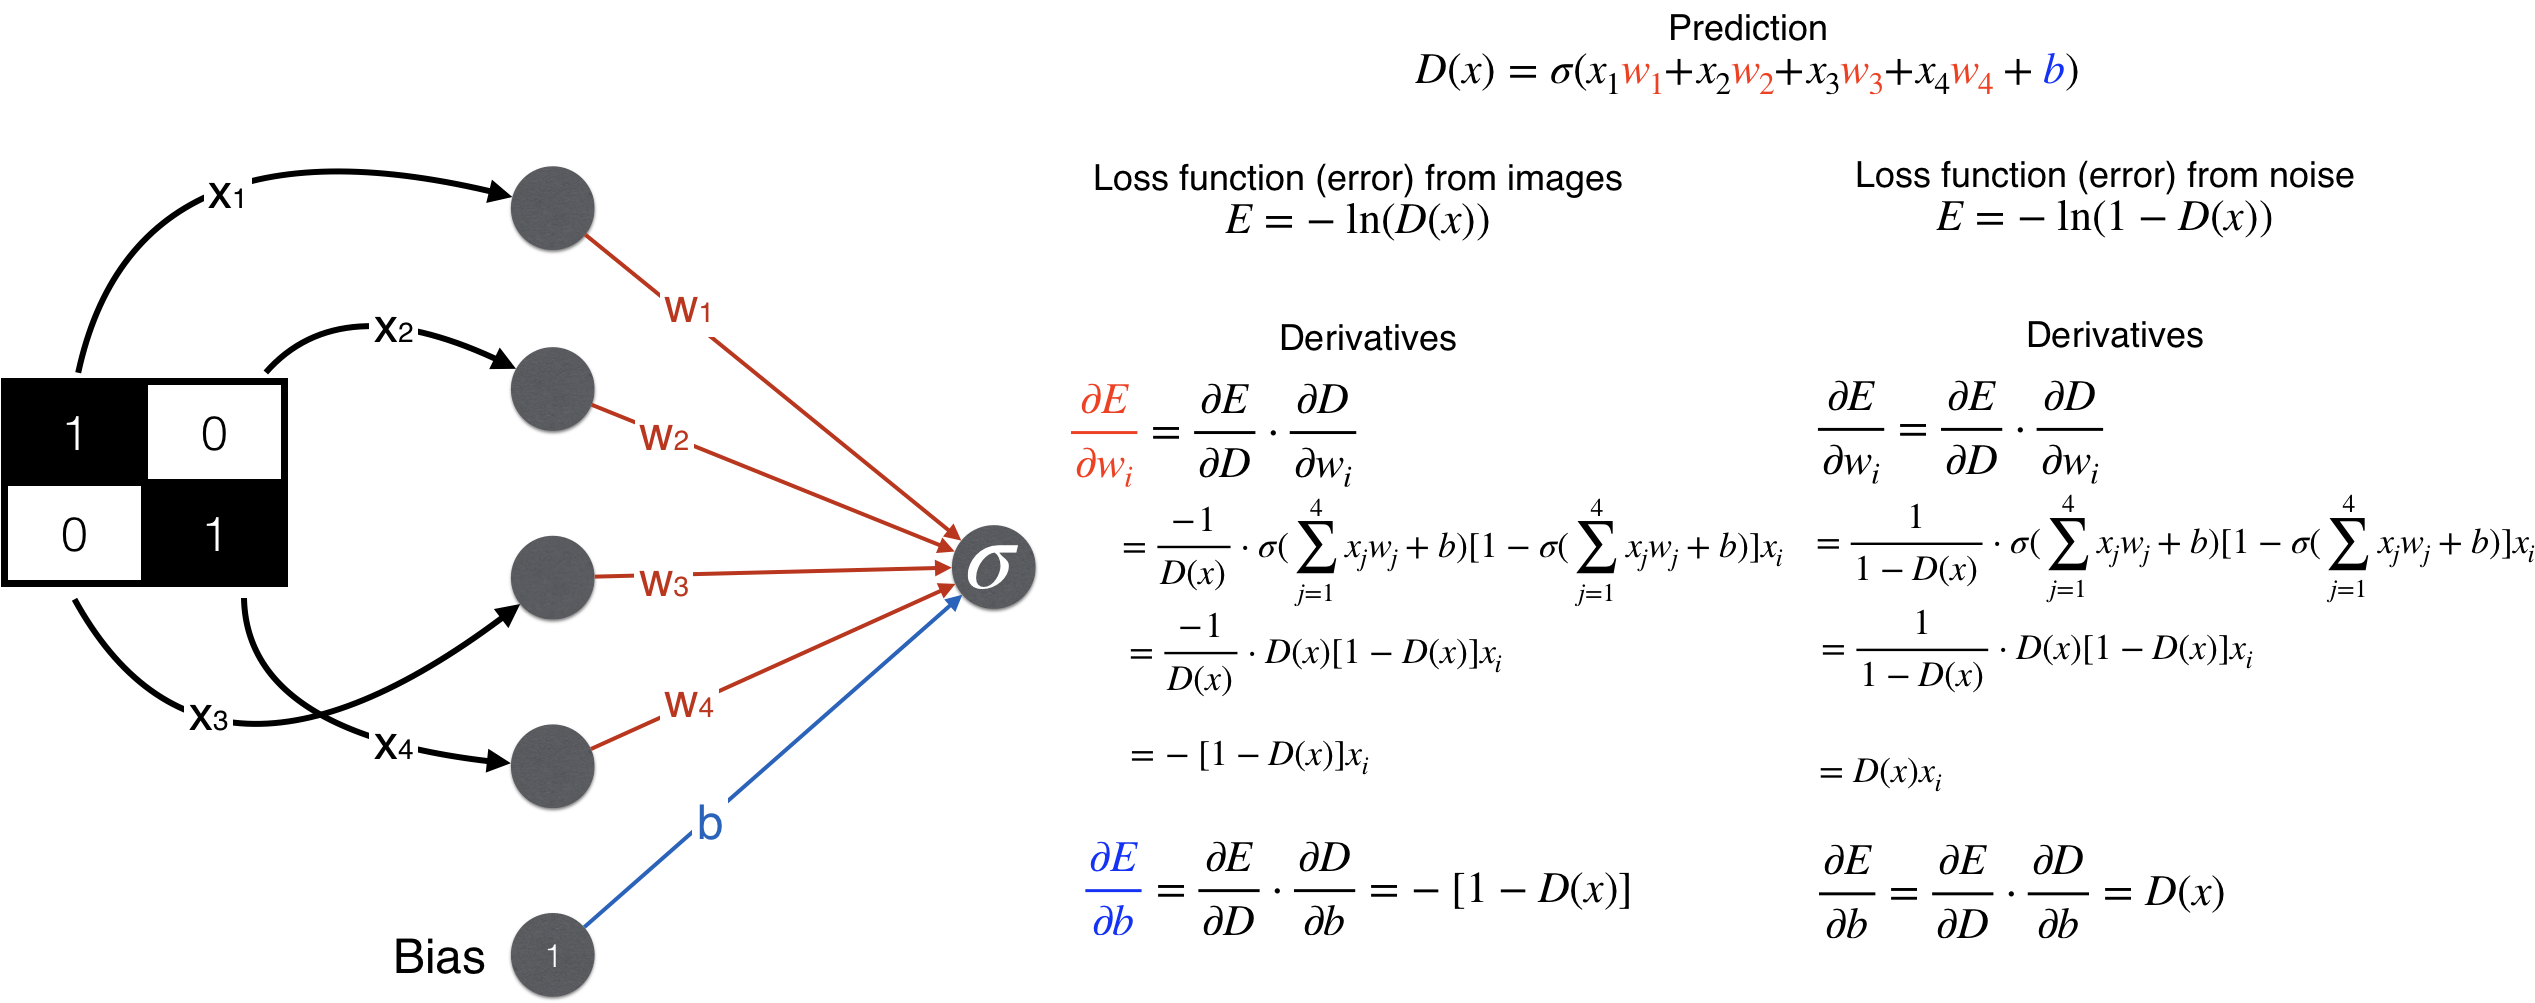

In [5]:
# Defining the function for the sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0 + np.exp(x))

# Building the Discriminator class
class Discriminator():
    # initial weights and bias
    def __init__(self, learning_rate):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
        self.learning_rate = learning_rate
    
    # Forward pass
    def forward(self,X):
        return sigmoid(np.dot(X,self.weights) + self.bias)
    
    # Error calculation from image
    def error_from_image(self,image):
        pred = self.forward(image)
        # We want positive prediction, so E = -ln(D(x)) = -ln(pred)
        return -np.log(pred)
    
    # Obtaining derivative values before back propagation
    def deriv_from_images(self,image):
        dx = self.forward(image)
        d_wts = -(1-dx)*image
        d_bias = -(1-dx)
        return d_wts,d_bias
    
    # Updating the weights for Discriminator trained on real images
    def update_from_image(self,x):
        dervs = self.deriv_from_images(x)
        self.weights -=self.learning_rate*dervs[0]
        self.bias -=self.learning_rate*dervs[1]
    
    # Error calculation from noise
    def error_from_noise(self,noise):
        pred = self.forward(noise)
        # We want negative prediction, so E = -ln(1-D(x)) = -ln(1-pred)
        return -np.log(1-pred)
    
    # Obtaining derivative values fro back propagation (Point no. 4)
    def deriv_from_noise(self,noise):
        dx = self.forward(noise)
        dwts_n = (dx)*noise
        dbias_n = dx
        return dwts_n,dbias_n
    
    # Updating the weights for Discriminator trained on noisy images
    def update_from_noise(self,noise):
        dervs = self.deriv_from_noise(noise)
        self.weights -=self.learning_rate*dervs[0]
        self.bias -=self.learning_rate*dervs[1]

### Generator

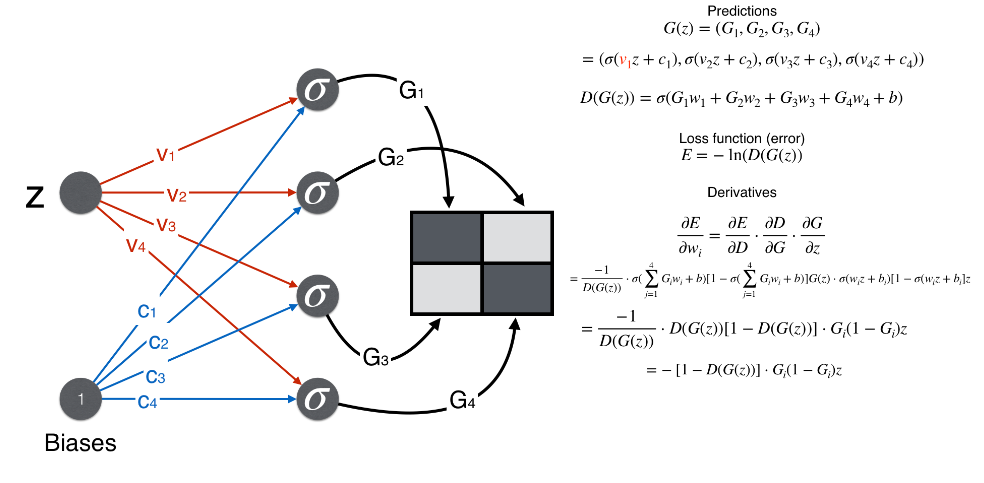
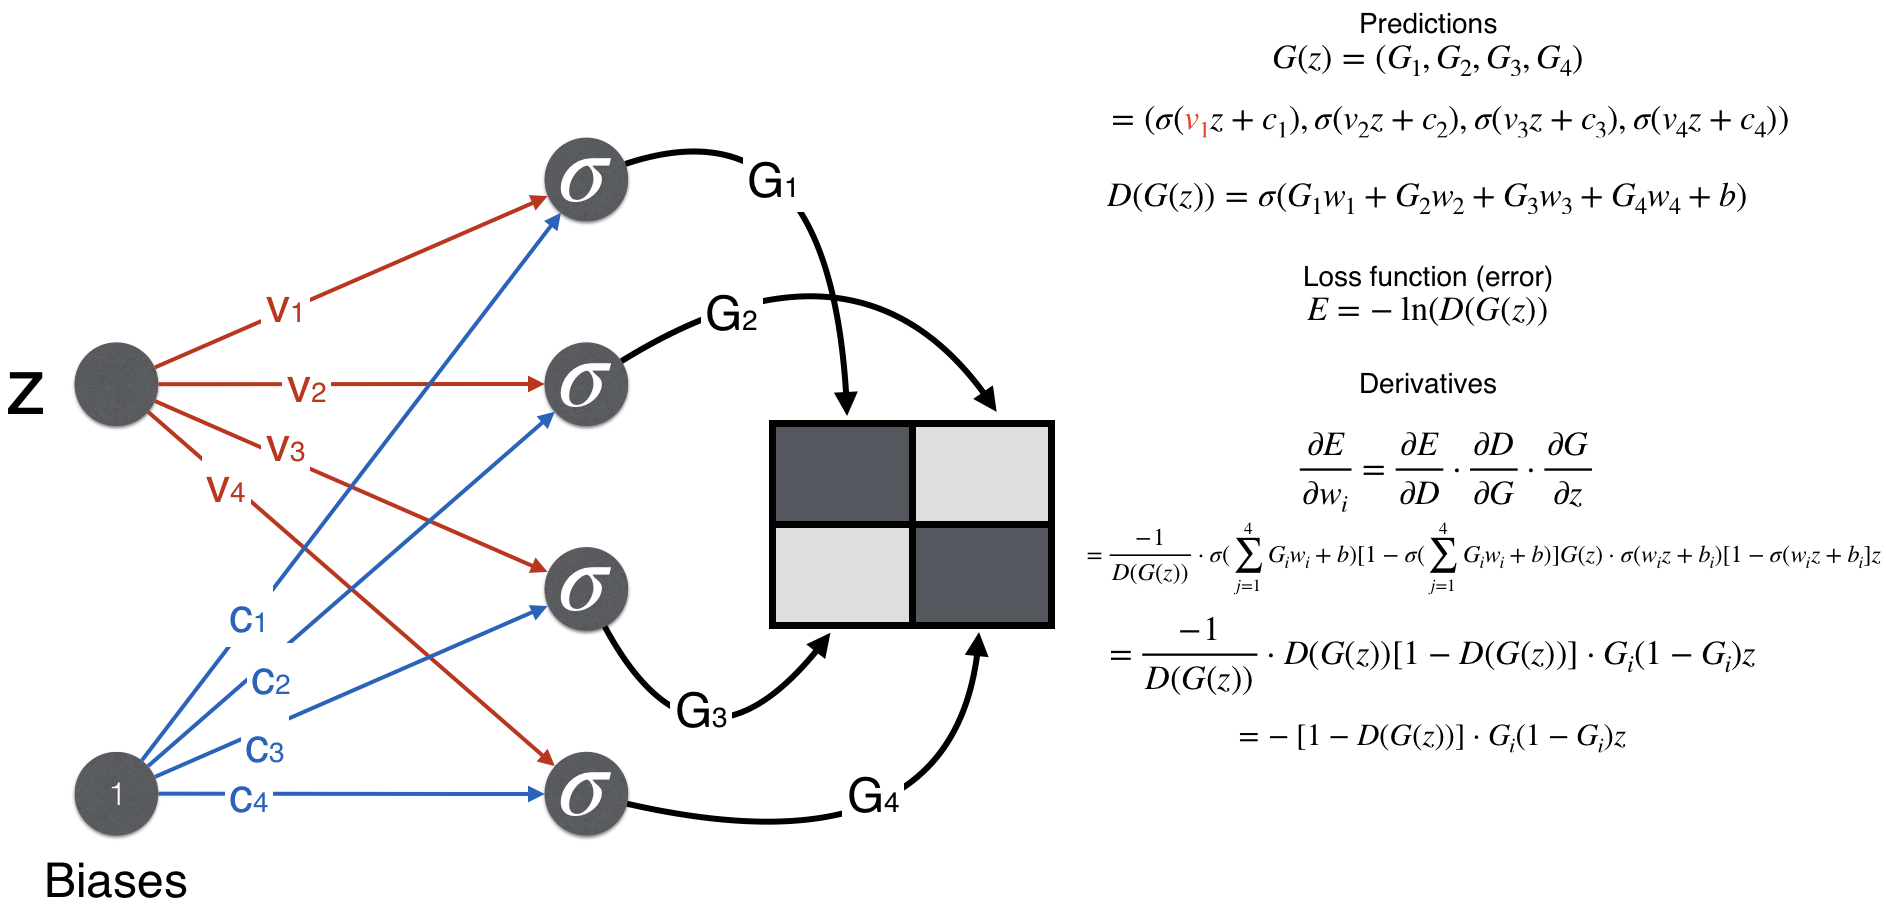

In [6]:
# Building the Generator class
class Generator():
    # Initial weights and bias
    def __init__(self, learning_rate):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.array([np.random.normal() for i in range(4)])
        self.learning_rate = learning_rate
    # Forward pass
    def forward(self,z):
        return sigmoid(z*self.weights + self.bias)
    # Calculating error in a Generator produced image
    def error(self,z,d):
        x = self.forward(z)
        y = self.forward(x)
        return -np.log(y)
    # Get derivatives wrt weights
    def deriv(self,z,d):
        d_wts = d.weights
        d_bs = d.bias
        x = self.forward(z)
        y = d.forward(x)
        factor = -(1-y)*d_wts*x*(1-x)
        dwts_g = factor*z
        dbs_g = factor
        return dwts_g,dbs_g
    # Updating Discriminator weights
    def update(self,z,d):
        err_before = self.error(z,d)
        ders = self.deriv(z,d)
        self.weights -= self.learning_rate*ders[0]
        self.bias -= self.learning_rate*ders[1]
        err_after = self.error(z,d)

### Training the GAN

In [7]:
np.random.seed(45)        # Setting seed value

# Set hyperparameters
learning_rate = 0.01
epochs = 25000

# Setting up the GAN
# 1. The Discriminator
D = Discriminator(learning_rate)
# 2. The Generator
G = Generator(learning_rate)

err_D, err_G = [],[]   # To store error values and plot them later.
for e in range(epochs):
    for s in samples:
        # Doing step-by-step
        # 1. Updating D with weights and bias from real image
        D.update_from_image(s)
        # 2. Picking a random value of z to initiate the process of producing a Generator.
        z = rand()
        # 3. Calculate Discriminator error
        '''Error = -ln(D(x)) - ln(1-D(x)) 
                  = -ln(D(s)) - ln(1-D(z))'''
        err_D.append(sum(D.error_from_image(s) + D.error_from_noise(z)))
        # 4. Calculate Generator error
        ''' Error = -ln(D(G(z))) '''
        err_G.append(G.error(z,D))
        # 5. Build the fake image
        noise = G.forward(z)
        # 6. Backpropagate to update discriminator weights from fake face
        D.update_from_noise(noise)
        # 7. Backpropagate to update generator weights from fake face
        G.update(z,D)

### Generating the images

[[0.92081369 0.13055755]
 [0.15500058 0.85581462]] 

[[0.94963721 0.14605581]
 [0.22567268 0.78121113]] 

[[0.90314821 0.12395698]
 [0.12927869 0.88216031]] 

[[0.91908764 0.12984277]
 [0.15208273 0.85882901]] 



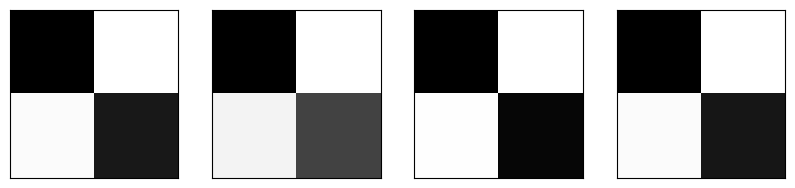

In [8]:
# 1. Plotting
generated_images = []
for i in range(4):
    z = rand()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_images(generated_images, 1, 4)

# Printing the matrix values
for img in generated_images:
    print(img.reshape(2,2),"\n")

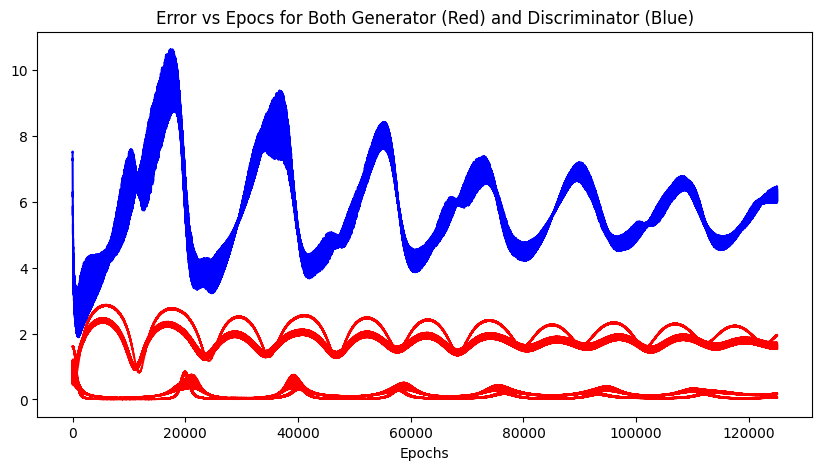

In [9]:
# 2. Plotting the error vs epoch lapse for both the Discriminator and the Generator
plt.figure(figsize=(10,5))
plt.plot(err_G,color='red',label="Generator")
plt.plot(err_D,color='blue',label="Discriminator")
plt.xlabel("Epochs")
plt.title("Error vs Epocs for Both Generator (Red) and Discriminator (Blue)")
plt.show()

In [10]:
# 3. Printing the weights and bias related to each Network.
# The Discriminator
print("The Discriminator : \nThe final weights = {}\nThe final bias = {}".format(D.weights,D.bias))
print("\nThe Generator : \nThe final weights = {}\nThe final biases = {}".format(G.weights,G.bias))

The Discriminator : 
The final weights = [-0.25152788 -0.34186464 -0.03561004 -0.17626775]
The final bias = 0.4125750716261406

The Generator : 
The final weights = [-1.48959401 -0.40111232 -1.42680455  1.5661502 ]
The final biases = [ 2.96642784 -1.75790638 -1.20455641  1.24161663]
